In [1]:
#%matplotlib notebook
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import glob
import os.path
import scipy.io
import skimage.io

Script used to make this data is in `/bf_pulse/workflows/lsm700_sigbyfp.sh`

# First Lets look at the raw histograms. 

In [19]:
data_path = "../../datasets/LSM700_63x_sigb/bg_values_eugene2"
bgsub_dir = "../../proc_data/slice63x_bg_subtract_eugene2/December_2014/"
sbsub_dir = "../../proc_data/slice63x_sigb_yfp/images/"

In [9]:

WTonly = [ f for f in glob.glob(bgsub_dir + "**/WT*.lsm", recursive=True) if "/10x/" not in f]
RFPonly = [ f for f in glob.glob(bgsub_dir + "**/RFP*.lsm", recursive=True) if "/10x/" not in f]
YFPRFP = [ f for f in glob.glob(sbsub_dir + "**/SigB_72*center*stitched.tiff", recursive=True) if "/segmented/" not in f]

In [11]:
def get_file_dirname(path):
    filename = os.path.splitext(os.path.basename(path))[0]
    dirname = os.path.dirname(path)
    return dirname, filename

In [12]:
def get_pixels(imagepath, maskname, color):
    dirname, basename = get_file_dirname(imagepath)
    basepath = os.path.join(dirname, basename, basename)
    datapath = basepath + "_" + maskname + ".mat"
    imgpath = basepath + "_c{0}.tiff".format(color[0])
    if maskname == "distmap":
        dm = scipy.io.loadmat(datapath)["distmap_masked"]
        data = (dm<20) & (dm>0) # just tops
    else:
        data = scipy.io.loadmat(datapath)["image"]
    img = skimage.io.imread(imgpath)
    return np.ravel(img[data==1])


In [13]:
def get_all_pixels(list_of_files, mask):
    return np.hstack([get_pixels(f, mask, "green") for f in list_of_files])

In [14]:
bg = get_all_pixels(WTonly+RFPonly, "background")
af = get_all_pixels(RFPonly, "segmented")
sb = get_all_pixels(YFPRFP, "distmap")

### Load up the computed mean levels. 

In [20]:
with open(data_path + ".json") as fp:
    redux_means_63x = json.load(fp)

In [21]:
redux_means_63x

{'green_actual_all': 1653.705500821975,
 'green_actual_bottom': 1215.6286682946725,
 'green_actual_top': 3360.2710395946697,
 'green_autofluor': 208.75530075428523,
 'green_bg': 131.9007879583791,
 'green_bleedthrough': 248.81361347039845,
 'green_raw_actual_all': 2176.470908222415,
 'green_raw_actual_bottom': 1728.1424628704567,
 'green_raw_actual_top': 3911.728711859721,
 'red_autofluor': 22.948440851191496,
 'red_bg': 276.8907637053417}

Show the histograms used to compute these values and overlay the means. 

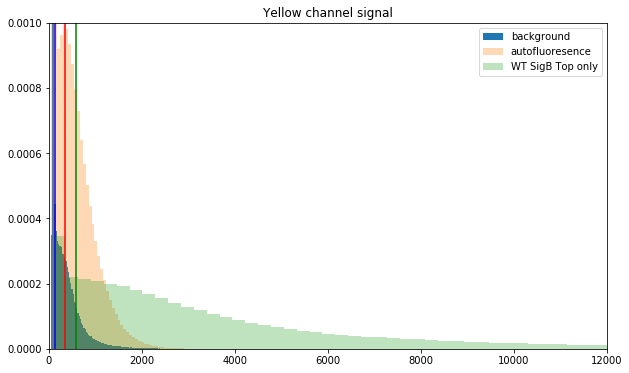

In [22]:
plt.figure(figsize=(10,6))
ymax = 0.001
plt.hist(bg, bins=200, density=True, alpha=1.0, label="background");
plt.vlines(redux_means_63x["green_bg"], 0, ymax, color="blue")
plt.hist(af, bins=200, density=True, alpha=0.3, label="autofluoresence");
plt.vlines(redux_means_63x["green_bg"] + redux_means_63x["green_autofluor"], 0, ymax, color="red")
plt.hist(sb, bins=200, density=True, alpha=0.3, label="WT SigB Top only")
plt.vlines(redux_means_63x["green_bg"] + redux_means_63x["green_autofluor"] + redux_means_63x["green_bleedthrough"], 0, ymax, color="green")
plt.legend()
plt.ylim(0, ymax)
plt.xlim(0, 12000)
plt.title("Yellow channel signal")
plt.show() # make figure visible in gitlab

So there is quite an overlap with the Top YFP signal and autofluoresence

## The numbers for the individual images. 

In [23]:
bleed_redux = pd.read_csv(data_path +".tsv", sep="\t", index_col="index")

In [24]:
bleed_redux.drop(['dir_name'], axis=1)

,file_name,strain,green_bg,green_autofluor,green_bleedthrough,green_actual_top,green_actual_all,green_actual_bottom,green_raw_actual_top,green_raw_actual_all,green_raw_actual_bottom,red_bg,red_autofluor
index,,,,,,,,,,,,,
0,RFP_only_72hrs_base2_2_Eugene_2_settings,RFP,162.888965,NaN,225.318713,NaN,NaN,NaN,NaN,NaN,NaN,330.301386,NaN
1,RFP_only_72hrs_base_2_Eugene_2_settings,RFP,134.884841,NaN,251.477945,NaN,NaN,NaN,NaN,NaN,NaN,344.837448,NaN
2,RFP_only_72hrs_base_Eugene_2_settings,RFP,185.625205,NaN,202.745165,NaN,NaN,NaN,NaN,NaN,NaN,272.877087,NaN
3,RFP_only_72hrs_middle_2_Eugene_2_settings,RFP,126.456983,NaN,273.438245,NaN,NaN,NaN,NaN,NaN,NaN,481.927768,NaN
4,RFP_only_72hrs_middle_Eugene_2_settings,RFP,127.531182,NaN,252.202908,NaN,NaN,NaN,NaN,NaN,NaN,244.863949,NaN
5,RFP_only_72hrs_top_2_Eugene_2_settings,RFP,103.323177,NaN,283.296675,NaN,NaN,NaN,NaN,NaN,NaN,204.010627,NaN
6,RFP_only_72hrs_top_Eugene_1_modified_settings,RFP,116.453067,NaN,253.215643,NaN,NaN,NaN,NaN,NaN,NaN,265.672799,NaN
7,WT_72hrs_center_base_Eugene_2_settings,WT,NaN,227.240507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.331263
8,WT_72hrs_center_top_Eugene_2_settings,WT,98.042883,190.270095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.635047,15.565618


In [25]:
def area_plots(ax, df, mean_vals, columns, labels, colors):
    ax = df[columns].plot.area(ax=ax, linewidth=0, color=colors)
    leg = ax.get_legend() 
    for l, t in zip(leg.get_texts(), labels):
        l.set_text(t)
    #leg.set_loc("upper left")
    total = 0
    artists = []
    for col in columns:
        total += mean_vals[col]
        ax.axhline(total, linewidth=1.0, color="black")
        #ax.annotate()
    ax.set_xlabel("")
    return ax, artists

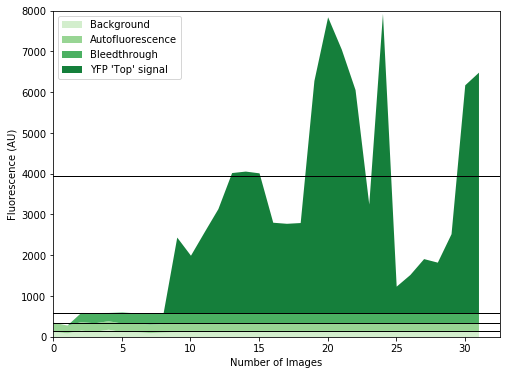

In [26]:
indiv_df = bleed_redux.copy()
means_df = redux_means_63x.copy()

indiv_df["strain"] = pd.Categorical(indiv_df["strain"], categories=["WT", "RFP", "SigB"], ordered=True)
indiv_df.sort_values(by=["strain"], inplace=True)
indiv_df = indiv_df.reset_index(drop=True)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 6)


columns_green = ['green_bg',
                'green_autofluor',
                'green_bleedthrough',"green_actual_top" ] 
new_labels = ["Background", "Autofluorescence", "Bleedthrough", "YFP 'Top' signal"]

n = len(columns_green)+1
greens = [plt.cm.Greens(i/n) for i in range(1, n)]

indiv_df.loc[indiv_df["green_bg"].isnull(), "green_bg"] = means_df["green_bg"]
indiv_df.loc[indiv_df["strain"]=="RFP", "green_autofluor"] = means_df["green_autofluor"]
indiv_df.loc[indiv_df["strain"]=="SigB", "green_autofluor"] = means_df["green_autofluor"]
indiv_df.loc[indiv_df["strain"]=="SigB", "green_bleedthrough"] = means_df["green_bleedthrough"]

ax,_ = area_plots(ax, indiv_df, means_df, columns_green, new_labels, greens)

a = ax
a.get_yaxis().set_tick_params(direction='out')
a.get_xaxis().set_tick_params(direction='out')
a.set_xlim(left=0)
a.set_ylim(0, 8000)
a.set_xlabel("Number of Images")
a.set_ylabel("Fluorescence (AU)")
plt.show() # make figure visible in gitlab

## Bleed through from the RFP channel counts for

### Ratio of bleed through to the YFP signal 

In [27]:
redux_means_63x["green_bleedthrough"]/redux_means_63x["green_actual_top"]

0.0740456976650346

### Proportion of Green Signal that is RFP (estimated from means)

In [28]:
green_signal =  sum([ redux_means_63x[k] for k in ["green_bg", "green_autofluor", "green_bleedthrough", "green_actual_top"]])

In [29]:
redux_means_63x["green_bleedthrough"]/green_signal

0.06299492289167576

### Proportion of Green Signal that is RFP (from raw signal)

In [30]:
redux_means_63x["green_bleedthrough"]/redux_means_63x["green_raw_actual_top"]

0.06360707293326255